### Extração, Transformação e Carga do conjunto de dados

O arquivo m_3330.csv utilizado neste trabalho foi previamente tratado conforme explicado aqui:
https://github.com/dssantos/alibaba-datacenter-workload/blob/main/extract_transform_load.ipynb

### Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

### Conjunto de dados

In [2]:
# Carrega o conjunto de dados 'm_3330.csv' e ajusta o intervalo de tempo em 1 minuto

def dataframe(file):
    df = pd.read_csv(file, 
                 names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                          'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
    df.time_stamp = pd.to_datetime(df.time_stamp, unit='s')
    df.set_index('time_stamp', inplace=True)
    df = df.resample('1min').interpolate()
    return df

workload = dataframe('m_3330.csv')
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


### Uso de CPU

<AxesSubplot:xlabel='time_stamp'>

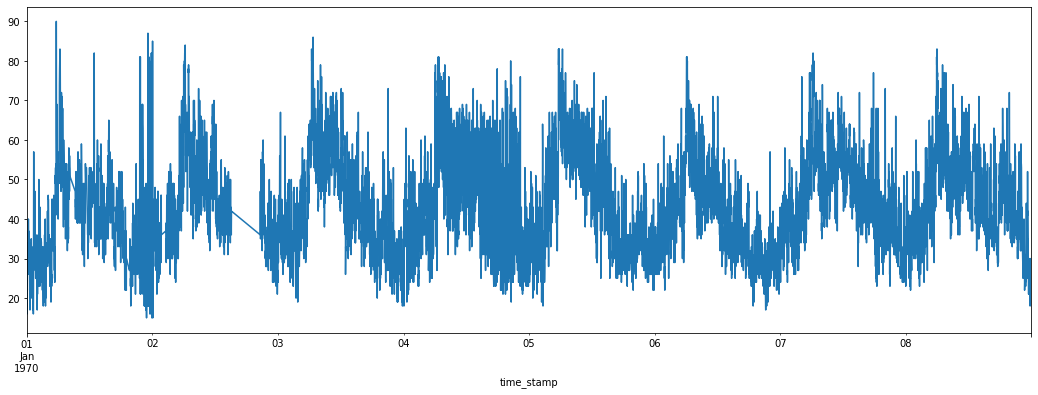

In [3]:
workload['cpu'].plot(figsize=(18,6))

### Análise da série temporal

<AxesSubplot:xlabel='time_stamp'>

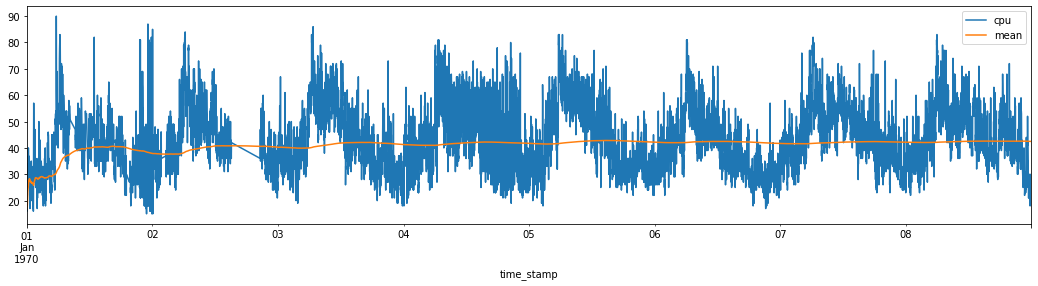

In [4]:
# Verifica se a média é constante ao longo do tempo (característica estacionária)

workload['mean'] = [np.mean(workload.cpu[:x]) for x in range(len(workload.cpu))]
workload[['cpu','mean']].plot(figsize=(18,4))

In [5]:
# Usando o teste Augmented Dickey-Fuller para obter o Valor-P
# O método adfuller retorna uma tupla cujo segundo item é o Valor-P
# Caso o Valor-P seja inferior a 5%, então a série é estacionária

result = adfuller(workload['cpu'])

print(f'adf: {result[0]:.2f}')
print(f'pvalue: {result[1]:.2f}')
print(f'usedlag: {result[2]:.2f}')
print(f'nobs: {result[3]:.2f}')
for key, value in result[4].items():
    print(f'{key} critical value: {value:.2f}')
print(f'icbest: {result[5]:.2f}')

adf: -5.76
pvalue: 0.00
usedlag: 36.00
nobs: 11483.00
1% critical value: -3.43
5% critical value: -2.86
10% critical value: -2.57
icbest: 76552.25


### Separar conjuntos de treino e  teste

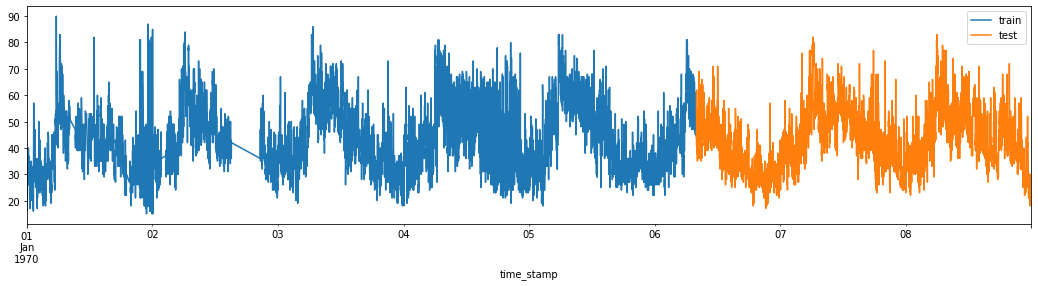

In [6]:
test_len = len(workload)//3
train = workload.iloc[:-test_len] # Conjunto de treino
test = workload.iloc[-test_len:]  # Conjunto de teste

fig, ax = plt.subplots()
train.cpu.plot(figsize=(18,4), ax=ax)
test.cpu.plot(figsize=(18,4), ax=ax)
ax.legend(["train", "test"])